# Solving ILPs using Branch and Bound Algorithm

We will now present how the branch-and-bound algorithm for solving integer linear programs works. Branch-and-Bound is an important and practical algorithm for solving ILPs. Together with a lot of other approaches such as _cutting planes_ and _lift and project_ methods, it forms the basis for how commercial solvers approach solving ILPs. 

We will describe a simple branch-and-bound algorithm here but note that a lot of key implementation details will be left out: they are covered in a more detailed course on the topic of linear programming/combinatorial optimization.

## Integer Linear Programming Problem

We will consider integer programming problems of the following form:

<div class="alert alert-block" style="border-color:black white black white">
    $$\begin{array}{rll}
    \max & c_1 x_1 + \cdots + c_n x_n & \leftarrow\ \text{objective function} \\
    \mathsf{s.t.} & a_{i1} x_1 + \cdots + a_{in} x_n \ \leq\ b_i & \leftarrow\ \text{for}\ i = 1, \ldots, m \\ 
    & \ell_i \ \leq\ x_i\ \leq\ u_i & \leftarrow\ \text{for}\ i = 1, \ldots, n\\ 
    & x_1, \ldots, x_n \in \mathbb{Z} \\ 
    \end{array}$$
</div>

Note that the decision variables are all integers. Also, for convenience, we separate out the constraints that are bounds on individual decision variables so that we store the bounds for each variable $x_i$ as lower bound $\ell_i$ and upper bound $u_i$ as shown in the third line of the problem formulation above. Note that if there is no lower bound then $\ell_i = -\infty$ and if there is no upper bound then $u_i = \infty$. We will assume $\ell_i \leq u_i$ for all $i$ or else, the problem is infeasible right away.

Recall that the LP relaxation of the ILP simply drops the integrality constraint $x_1, \ldots, x_n \in \mathbb{Z}$ and allows the decision variables to take on real-number values. 
  - This leads to efficient LP but the solution to the LP relaxation may be quite far away from the ILP solution, in general.
  - However, if the LP relaxation yields an integer optimal solution, then it has to also be an optimal solution for the ILP.
  
  
The key idea behind branch and bound is that it solves the LP relaxation hoping that we get an integer solution. If we fail to do so, then at least one of the decision variables $x_i$ has a fractional solution say for example we get $x_i^* = 2.56639898198$ which is not acceptable. However, in the original problem $x_i$ is an integer. So we know that its value is either $\leq 2$ or $\geq 3$ but cannot be something in the middle. Therefore, Branch and Bound algorithm splits the problem into two problems:
  - Original problem + constraint $x \leq 2$.
  - Original problem + constraint $x \geq 3$.
  
It recursively tackles the two sub problems and returns whichever answer is the largest since the original problem is a maximization problem. 




The basic branch and bound algorithm's pseudo-code is as follows. 

Inputs are the data for the ILP problem that includes:
  - Objective Coeffients: $(c_1, \ldots, c_n)$.
  - LHS constraint coefficients: $\left(\begin{array}{c} 
  a_{11} \ldots a_{1n} \\
  \ddots\\
  a_{m1} \ldots a_{mn}\\
  \end{array}\right)$.
  - RHS constant coefficients: $(b_1, \ldots, b_m)$.
  - Lower Bounds: $(\ell_1, \ldots, \ell_n)$.
  - Upper Bounds: $(u_1, \ldots, u_n)$.

<div class="alert alert-block" style="border-color:black white black white">
   <ol>
       <li> Solve the LP relaxation of the current ILP.
       <li> If the solution for $x_1, \ldots, x_n$ are all integers, then return the solution and objective values.
       <li> Otherwise, let $x_i$ be a variable whose optimal solution $x_i^*$ from step 1 is not an integer.
           <ol>
               <li> Create a new ILP from the input problem data but with upper bound of $x_i$ modified to $\lfloor x_i^* \rfloor$. Effectively, we have added the new constraint $x_i \leq \lfloor x_i^* \rfloor$ to the problem. Solve this ILP recursively.
                   <ol>
                       <li> If it has an optimal solution, let  $s_1^*$ denote the objective value.
                       <li> If it is infeasible, set $s_1^* = - \infty$.
                        <li> If it is unbounded, the original ILP is also unbounded. STOP and return UNBOUNDED.
                   </ol>
               <li> Create a new ILP from the input problem data with lower bound for $x_i$ modified to $\lceil x_i^* \rceil$. Effectively, we have added the new constraint $x_i \geq \lceil x_i^* \rceil$ to the problem. Solve this ILP recursively.
                    <ol>
                       <li> If it has an optimal solution, let  $s_2^*$ denote the objective value.
                       <li> If it is infeasible, set $s_2^* = - \infty$.
                        <li> If it is unbounded, the original ILP is also unbounded. STOP and return UNBOUNDED.
                   </ol>
               <li> Return $\max(s_1^*, s_2^*)$ as the optimal solution to the original ILP.
           </ol>
    </ol>
</div>


In [2]:
class Stats:
    def __init__(self):
        self.max_depth = 0
        self.num_lps = 0
        self.num_infeas = 0
        
    def print(self):
        print('Statistics')
        print('---------------------------------')
        print(f'Number of LPs Solved: {self.num_lps}')
        print(f'Number of infeasible LPs: {self.num_infeas}')
        print(f'Max. Recursion Depth: {self.max_depth}')
        print('---------------------------------')

In [3]:
from pulp import *
from math import floor, ceil

# Given a list of numbers, find all indices in the list that correspond to fractional numbers.
# we use the function is_fractional to define what it means to be "fractional" -- we have to 
# account for floating point errors in this criterion
def find_all_fractional_indices(sols):
    n = len(sols)
    def is_fractional(f):
        epsilon = 0.001 # this is the precision to which we check whether something is an integer
        return  epsilon <= (f - floor(f)) <= 1-epsilon
    return [j for j in range(n) if is_fractional(sols[j]) ]

# This is the main function. 
# stats keeps track of statistics of number of LPs solved, infeasible and max. depth of recursion.
def branch_and_bound_solve(c, A, b, lb, ub, stats, depth=1, debug=True):
    n = len(c)
    m = len(A)
    assert all( len(ai) == n for ai in A), 'All rows in A must have same length'
    assert len(b) == m
    assert len(lb) == n
    assert len(ub) == n
    ## This function is just for pretty printing the tabs
    def indent():
        for _ in range(depth-1):
            print('|  ', end='')
        print(u'\u21B3', end='')
        
    if any(lb[i] > ub[i] for i in range(n)): # if any lower bound is greater than upper bound, problem is infeasible, BAIL
        if debug:
            indent()
            print('Infeasibility detected due to lb[i]> ub[i].')
        return (-float('inf'), None)
   
    # Record statistics
    if depth > stats.max_depth:
        stats.max_depth = depth
    stats.num_lps = stats.num_lps + 1
    ## 1. PART  1: Setup and Solve the LP Relaxation
    # setup and solve the LP
    prob = LpProblem('b_and_b', LpMaximize) # create the problem
    # declare all the variables, set the upper and lower bound here
    # Note: variables are set to "Continuous" since we are solving the LP relaxation
    dvars = [LpVariable(f'x{i}', lowBound=lb[i], upBound=ub[i],cat='Continuous') for i in range(n)]
    # add the objective function -- we already set it to maximize
    prob += lpSum([ci*xi for (ci,xi) in zip(c, dvars)])
    # add the constraints for each row
    for (ai, bi) in zip(A,b):
        prob += lpSum([ aij*xj for (aij,xj) in zip(ai, dvars)]) <= bi
    #Let's solve the problem but supress the output
    status = prob.solve(apis.PULP_CBC_CMD(mip=False, msg=False))
    # Check the problem status
    if status == constants.LpStatusInfeasible: # infeasible?
        if debug:
            indent()
            print('Infeasible Problem: returning -\infty')
        stats.num_infeas = stats.num_infeas + 1
        return (-float('inf'), None) # return objective value of -infinity
    elif status == constants.LpStatusUnbounded: # unbounded
        if debug: 
            indent()
            print('Unbounded Problem: returning + \infty')
        return (float('inf'), None) # return objective value of +infinity
    else: # optimal?
        assert status == LpStatusOptimal, 'Problem results in undefined status -- cannot continue'
        sols = [x.varValue for x in dvars] # extract the solutions for each decision variable
        obj_value = sum([ci*xi for (ci, xi) in zip(c, sols)]) # compute objective value
        if debug:
            indent()
            print(f'Obtained solution: {sols} with objective {obj_value}')
        ## PART 2: Branch and Bound Solve
        # check if the solution is integral
        jList = find_all_fractional_indices(sols)
        if len(jList) == 0: # no fractional values 
            if debug:
                indent()
                print('All variables are integral in optimal solution.')
                indent()
                print(f'Returning solution: {sols} with objective {obj_value}')
            return (obj_value, sols) # done
        else:
            ## This is the part where we branch
            split_var = jList[0]
            assert 0 <= split_var < n
            if debug:
                indent()
                print(f'Splitting variable : {split_var} which has a current solution {sols[split_var]}')
            # adjust the upper bound 
            tmp = ub[split_var]
            ub[split_var] = floor(sols[split_var])
            if debug: 
                indent()
                print(f'Branch #1: Adding x{split_var} <= {ub[split_var]}')
            (obj1,sols1) = branch_and_bound_solve(c, A, b, lb, ub, stats, depth+1, debug)
            if obj1 == float('inf'):
                return (obj1, sols1)
            ub[split_var] = tmp
            # adjust the lower bound
            tmp = lb[split_var]
            lb[split_var] = ceil(sols[split_var])
            if debug: 
                indent()
                print(f'Branch #2: Adding x{split_var} >= {lb[split_var]}')
            (obj2, sols2) = branch_and_bound_solve(c, A, b, lb, ub, stats, depth+1, debug)
            lb[split_var] = tmp
            if obj2 == float('inf'): # unbounded 
                return (obj2, sols2)
            # compare solutions and return
            if obj1 < obj2: # which solution is larger?
                if debug:
                    indent()
                    print(f'Returning solution: {sols2} with objective {obj2}')
                return (obj2, sols2)
            else:
                if debug:
                    indent()
                    print(f'Returning solution: {sols1} with objective {obj1}')
                return (obj1, sols1)
    

### Example 1

$\begin{array}{rl}
\max & x_1 + x_2 - x_3 \\ 
\mathsf{s.t.} & x_1 - x_2  \leq 2.5 \\ 
& x_2 - x_3 \leq 1.2 \\ 
& x_1 - x_3 \leq 3.1 \\ 
& x_1 + x_2 + x_3 \leq 4.3 \\ 
& -2 \leq x_i \leq 2,\ i = 1,2, 3\\
\end{array}$

In [4]:
# Let's test it
c = [1, 1, -1]
A = [[1, -1, 0], [0, 1, -1], [1, 0, -1], [1, 1, 1]]
b = [2.5, 1.2, 3.1, 4.3]
lb = [-2, -2, -2]
ub = [2, 2, 2]
stats = Stats()
branch_and_bound_solve(c, A, b, lb, ub, stats)
stats.print()

↳Obtained solution: [2.0, 0.1, -1.1] with objective 3.2
↳Splitting variable : 1 which has a current solution 0.1
↳Branch #1: Adding x1 <= 0
|  ↳Obtained solution: [1.9, 0.0, -1.2] with objective 3.0999999999999996
|  ↳Splitting variable : 0 which has a current solution 1.9
|  ↳Branch #1: Adding x0 <= 1
|  |  ↳Obtained solution: [1.0, -0.8, -2.0] with objective 2.2
|  |  ↳Splitting variable : 1 which has a current solution -0.8
|  |  ↳Branch #1: Adding x1 <= -1
|  |  |  ↳Obtained solution: [1.0, -1.0, -2.0] with objective 2.0
|  |  |  ↳All variables are integral in optimal solution.
|  |  |  ↳Returning solution: [1.0, -1.0, -2.0] with objective 2.0
|  |  ↳Branch #2: Adding x1 >= 0
|  |  |  ↳Obtained solution: [1.0, 0.0, -1.2] with objective 2.2
|  |  |  ↳Splitting variable : 2 which has a current solution -1.2
|  |  |  ↳Branch #1: Adding x2 <= -2
|  |  |  |  ↳Infeasible Problem: returning -\infty
|  |  |  ↳Branch #2: Adding x2 >= -1
|  |  |  |  ↳Obtained solution: [1.0, 0.0, -1.0] with 

### Example 2
$\begin{array}{rl}
\max & x_1 -2 x_2 +3 x_3 \\ 
\mathsf{s.t.} & x_1 - 3 x_2  \leq 7.1 \\ 
& 3 x_2 - x_3 \leq 4 \\ 
& 2 x_1 - 3 x_3 \leq 5 \\ 
& x_1 + x_2 + x_3 \leq 12.3 \\ 
& -5 \leq x_i \leq 5,\ i = 1,2, 3\\
\end{array}$


In [5]:
# Let's test it

c = [1, -2, 3]
A = [[1, -3, 0], [0, 3, -1], [2, 0, -3], [1, 1, 1]]
b = [7.1, 4, 5, 12.3]
lb = [-5, -5, -5]
ub = [5, 5, 5]
stats = Stats()
branch_and_bound_solve(c, A, b, lb, ub, stats)
stats.print()

↳Obtained solution: [5.0, -0.7, 5.0] with objective 21.4
↳Splitting variable : 1 which has a current solution -0.7
↳Branch #1: Adding x1 <= -1
|  ↳Obtained solution: [4.1, -1.0, 5.0] with objective 21.1
|  ↳Splitting variable : 0 which has a current solution 4.1
|  ↳Branch #1: Adding x0 <= 4
|  |  ↳Obtained solution: [4.0, -1.0333333, 5.0] with objective 21.066666599999998
|  |  ↳Splitting variable : 1 which has a current solution -1.0333333
|  |  ↳Branch #1: Adding x1 <= -2
|  |  |  ↳Obtained solution: [1.1, -2.0, 5.0] with objective 20.1
|  |  |  ↳Splitting variable : 0 which has a current solution 1.1
|  |  |  ↳Branch #1: Adding x0 <= 1
|  |  |  |  ↳Obtained solution: [1.0, -2.0333333, 5.0] with objective 20.066666599999998
|  |  |  |  ↳Splitting variable : 1 which has a current solution -2.0333333
|  |  |  |  ↳Branch #1: Adding x1 <= -3
|  |  |  |  |  ↳Obtained solution: [-1.9, -3.0, 5.0] with objective 19.1
|  |  |  |  |  ↳Splitting variable : 0 which has a current solution -1.9
|

### Example 3

Let's modify the bounds for decision variables in example 2


$\begin{array}{rl}
\max & x_1 -2 x_2 +3 x_3 \\ 
\mathsf{s.t.} & x_1 - 3 x_2  \leq 7.1 \\ 
& 3 x_2 - x_3 \leq 4 \\ 
& 2 x_1 - 3 x_3 \leq 5 \\ 
& x_1 + x_2 + x_3 \leq 12.3 \\ 
& -15 \leq x_i \leq 15,\ i = 1,2, 3\\
\end{array}$

In [6]:
# Let's test it

c = [1, -2, 3]
A = [[1, -3, 0], [0, 3, -1], [2, 0, -3], [1, 1, 1]]
b = [7.1, 4, 5, 12.3]
lb = [-15, -15, -15]
ub = [15, 15, 15]
stats = Stats()
branch_and_bound_solve(c, A, b, lb, ub, stats)
stats.print()

↳Obtained solution: [-0.25, -2.45, 15.0] with objective 49.65
↳Splitting variable : 0 which has a current solution -0.25
↳Branch #1: Adding x0 <= -1
|  ↳Obtained solution: [-1.0, -2.7, 15.0] with objective 49.4
|  ↳Splitting variable : 1 which has a current solution -2.7
|  ↳Branch #1: Adding x1 <= -3
|  |  ↳Obtained solution: [-1.9, -3.0, 15.0] with objective 49.1
|  |  ↳Splitting variable : 0 which has a current solution -1.9
|  |  ↳Branch #1: Adding x0 <= -2
|  |  |  ↳Obtained solution: [-2.0, -3.0333333, 15.0] with objective 49.0666666
|  |  |  ↳Splitting variable : 1 which has a current solution -3.0333333
|  |  |  ↳Branch #1: Adding x1 <= -4
|  |  |  |  ↳Obtained solution: [-4.9, -4.0, 15.0] with objective 48.1
|  |  |  |  ↳Splitting variable : 0 which has a current solution -4.9
|  |  |  |  ↳Branch #1: Adding x0 <= -5
|  |  |  |  |  ↳Obtained solution: [-5.0, -4.0333333, 15.0] with objective 48.0666666
|  |  |  |  |  ↳Splitting variable : 1 which has a current solution -4.033333

As you may notice, the performance of basic branch and bound even on a very small example is not very promising.
We can improve this along many axes. One simple improvement that can be made is to keep track of the "best solution so far".

### Pruning 
Suppose you are solving a problem using branch-and-bound + discover that you already have discovered an integer solution along some branch with an objective value of +10.  Let's say that on another branch, we solve a LP relaxation whose objective value is currently +9. We do not have to explore this branch any further. Because, 
remember the value of ILP will be <= LP relaxation. Therefore, even if we explored the current branch further, it will not yield a value greater than 9. But we already have a solution that is giving us a value of +10, which is better anyway.

This strategy is very common one in computer science: if you have taken an undergraduate artificial intelligence class, we study search problems and there it is called $\alpha-\beta$ pruning.


In [10]:
from pulp import *
from math import floor, ceil

# Given a list of numbers, find all indices in the list that correspond to fractional numbers.
# we use the function is_fractional to define what it means to be "fractional" -- we have to 
# account for floating point errors in this criterion
def find_all_fractional_indices(sols):
    n = len(sols)
    def is_fractional(f):
        epsilon = 0.001 # this is the precision to which we check whether something is an integer
        return  epsilon <= (f - floor(f)) <= 1-epsilon
    return [j for j in range(n) if is_fractional(sols[j]) ]


class Solution:
    # a class that will hold the best solution so far
    def __init__(self):
        self.obj_val = -float('inf') # initialize it to -infinity
        self.sol = None
    
    # replace current solution with a new one if it is better
    def replace(self, obj_val, new_sol):
        if obj_val > self.obj_val:
            self.obj_val = obj_val
            self.sol = new_sol
        return
    
# Branch and Bound with Pruning.
# The logic is almost identical to Branch and Bound but we pass around an extra argument
# that tracks the best solution so far
# We pass this argument as a class so that the reference to the class is passed. This allows
# changes made to the best solution so far in one branch to reflect elsewhere in the code.
# If you are unaware of this aspect of python, read about it here: https://www.geeksforgeeks.org/pass-by-reference-vs-value-in-python/#

def branch_and_bound_pruning_solve(c, A, b, lb, ub, best_sol_so_far, stats, depth=1, debug=True):
    n = len(c)
    m = len(A)
    assert all( len(ai) == n for ai in A), 'All rows in A must have same length'
    assert len(b) == m
    assert len(lb) == n
    assert len(ub) == n
    ## This function is just for pretty printing the tabs
    def indent():
        for _ in range(depth-1):
            print('|  ', end='')
        print(u'\u21B3', end='')
    # Check if all lower bounds are <= upper bounds, if not exit
    if any(lb[i] > ub[i] for i in range(n)): # if any lower bound is greater than upper bound, problem is infeasible, BAIL
        if debug:
            indent()
            print('Infeasibility detected due to lb[i]> ub[i].')
        return (-float('inf'), None)
    # record statistics
    if depth > stats.max_depth:
        stats.max_depth = depth
    stats.num_lps = stats.num_lps + 1
    # setup and solve the LP
    prob = LpProblem('b_and_b', LpMaximize) # create the problem
    # declare all the variables, set the upper and lower bound here
    # Note: variables are set to "Continuous" since we are solving the LP relaxation
    dvars = [LpVariable(f'x{i}', lowBound=lb[i], upBound=ub[i],cat='Continuous') for i in range(n)]
    # add the objective function -- we already set it to maximize
    prob += lpSum([ci*xi for (ci,xi) in zip(c, dvars)])
    # add the constraints for each row
    for (ai, bi) in zip(A,b):
        prob += lpSum([ aij*xj for (aij,xj) in zip(ai, dvars)]) <= bi
    #Let's solve the problem but supress the output
    status = prob.solve(apis.PULP_CBC_CMD(mip=False, msg=False))
    # Check the problem status
    if status == constants.LpStatusInfeasible: # infeasible?
        if debug:
            indent()
            print('Infeasible Problem: returning -\infty')
        stats.num_infeas = stats.num_infeas + 1
        return (-float('inf'), None) # return objective value of -infinity
    elif status == constants.LpStatusUnbounded: # unbounded
        if debug: 
            indent()
            print('Unbounded Problem: returning + \infty')
        return (float('inf'), None) # return objective value of +infinity
    else: # optimal?
        assert status == LpStatusOptimal, 'Problem results in undefined status -- cannot continue'
        sols = [x.varValue for x in dvars] # extract the solutions for each decision variable
        obj_value = sum([ci*xi for (ci, xi) in zip(c, sols)]) # compute objective value
        if debug:
            indent()
            print(f'Obtained solution: {sols} with objective {obj_value}')
        # is this objective less than the best so far?
        if obj_value < best_sol_so_far.obj_val: # if it is , then we do not need to go any further
            if debug:
                indent()
                print(f'Pruned solution: we already have an integer solution with objective {best_sol_so_far.obj_val}')
            return (-float('inf'), None) # it does not matter that we return a fake solution here since this will never beat the best solution so far.
 
        # check if the solution is integral
        jList = find_all_fractional_indices(sols)
        if len(jList) == 0: # no fractional values 
            if debug:
                indent()
                print('All variables are integral in optimal solution.')
                indent()
                print(f'Returning solution: {sols} with objective {obj_value}')
            if debug and obj_value > best_sol_so_far.obj_val:
                indent()
                print(f'This solution is the BEST SO FAR!!')
            best_sol_so_far.replace(obj_value, sols) # replace the best so far if appropriate.
            return (obj_value, sols) # done
        else:
            # solution is not integral
            split_var = jList[0]
            assert 0 <= split_var < n
            if debug:
                indent()
                print(f'Splitting variable : {split_var} which has a current solution {sols[split_var]}')
            # adjust upper bound 
            tmp = ub[split_var]
            ub[split_var] = floor(sols[split_var])
            if debug: 
                indent()
                print(f'Branch #1: Adding x{split_var} <= {ub[split_var]}')
            (obj1,sols1) = branch_and_bound_pruning_solve(c, A, b, lb, ub, best_sol_so_far,stats, depth+1, debug)
            if obj1 == float('inf'):
                return (obj1, sols1)
            ub[split_var] = tmp
            # adjust the lower bound
            tmp = lb[split_var]
            lb[split_var] = ceil(sols[split_var])
            if debug: 
                indent()
                print(f'Branch #2: Adding x{split_var} >= {lb[split_var]}')
            (obj2, sols2) = branch_and_bound_pruning_solve(c, A, b, lb, ub, best_sol_so_far, stats, depth+1, debug)
            lb[split_var] = tmp
            if obj2 == float('inf'): # unbounded 
                return (obj2, sols2)
            # compare solutions and return
            if obj1 < obj2: # which solution is larger?
                if debug:
                    indent()
                    print(f'Returning solution: {sols2} with objective {obj2}')
                return (obj2, sols2)
            else:
                if debug:
                    indent()
                    print(f'Returning solution: {sols1} with objective {obj1}')
                return (obj1, sols1)
    

In [11]:
# Example 1
c = [1, 1, -1]
A = [[1, -1, 0], [0, 1, -1], [1, 0, -1], [1, 1, 1]]
b = [2.5, 1.2, 3.1, 4.3]
lb = [-2, -2, -2]
ub = [2, 2, 2]
stats = Stats()
branch_and_bound_pruning_solve(c, A, b, lb, ub, Solution(), stats)
stats.print()

↳Obtained solution: [2.0, 0.1, -1.1] with objective 3.2
↳Splitting variable : 1 which has a current solution 0.1
↳Branch #1: Adding x1 <= 0
|  ↳Obtained solution: [1.9, 0.0, -1.2] with objective 3.0999999999999996
|  ↳Splitting variable : 0 which has a current solution 1.9
|  ↳Branch #1: Adding x0 <= 1
|  |  ↳Obtained solution: [1.0, -0.8, -2.0] with objective 2.2
|  |  ↳Splitting variable : 1 which has a current solution -0.8
|  |  ↳Branch #1: Adding x1 <= -1
|  |  |  ↳Obtained solution: [1.0, -1.0, -2.0] with objective 2.0
|  |  |  ↳All variables are integral in optimal solution.
|  |  |  ↳Returning solution: [1.0, -1.0, -2.0] with objective 2.0
|  |  |  ↳This solution is the BEST SO FAR!!
|  |  ↳Branch #2: Adding x1 >= 0
|  |  |  ↳Obtained solution: [1.0, 0.0, -1.2] with objective 2.2
|  |  |  ↳Splitting variable : 2 which has a current solution -1.2
|  |  |  ↳Branch #1: Adding x2 <= -2
|  |  |  |  ↳Infeasible Problem: returning -\infty
|  |  |  ↳Branch #2: Adding x2 >= -1
|  |  |  

In [12]:
# Example 2


c = [1, -2, 3]
A = [[1, -3, 0], [0, 3, -1], [2, 0, -3], [1, 1, 1]]
b = [7.1, 4, 5, 12.3]
lb = [-5, -5, -5]
ub = [5, 5, 5]
stats = Stats()

branch_and_bound_pruning_solve(c, A, b, lb, ub, Solution(), stats)
stats.print()

↳Obtained solution: [5.0, -0.7, 5.0] with objective 21.4
↳Splitting variable : 1 which has a current solution -0.7
↳Branch #1: Adding x1 <= -1
|  ↳Obtained solution: [4.1, -1.0, 5.0] with objective 21.1
|  ↳Splitting variable : 0 which has a current solution 4.1
|  ↳Branch #1: Adding x0 <= 4
|  |  ↳Obtained solution: [4.0, -1.0333333, 5.0] with objective 21.066666599999998
|  |  ↳Splitting variable : 1 which has a current solution -1.0333333
|  |  ↳Branch #1: Adding x1 <= -2
|  |  |  ↳Obtained solution: [1.1, -2.0, 5.0] with objective 20.1
|  |  |  ↳Splitting variable : 0 which has a current solution 1.1
|  |  |  ↳Branch #1: Adding x0 <= 1
|  |  |  |  ↳Obtained solution: [1.0, -2.0333333, 5.0] with objective 20.066666599999998
|  |  |  |  ↳Splitting variable : 1 which has a current solution -2.0333333
|  |  |  |  ↳Branch #1: Adding x1 <= -3
|  |  |  |  |  ↳Obtained solution: [-1.9, -3.0, 5.0] with objective 19.1
|  |  |  |  |  ↳Splitting variable : 0 which has a current solution -1.9
|

In [13]:
#Exampl 3
c = [1, -2, 3]
A = [[1, -3, 0], [0, 3, -1], [2, 0, -3], [1, 1, 1]]
b = [7.1, 4, 5, 12.3]
lb = [-15, -15, -15]
ub = [15, 15, 15]
stats = Stats()
branch_and_bound_pruning_solve(c, A, b, lb, ub, Solution(), stats)
stats.print()

↳Obtained solution: [-0.25, -2.45, 15.0] with objective 49.65
↳Splitting variable : 0 which has a current solution -0.25
↳Branch #1: Adding x0 <= -1
|  ↳Obtained solution: [-1.0, -2.7, 15.0] with objective 49.4
|  ↳Splitting variable : 1 which has a current solution -2.7
|  ↳Branch #1: Adding x1 <= -3
|  |  ↳Obtained solution: [-1.9, -3.0, 15.0] with objective 49.1
|  |  ↳Splitting variable : 0 which has a current solution -1.9
|  |  ↳Branch #1: Adding x0 <= -2
|  |  |  ↳Obtained solution: [-2.0, -3.0333333, 15.0] with objective 49.0666666
|  |  |  ↳Splitting variable : 1 which has a current solution -3.0333333
|  |  |  ↳Branch #1: Adding x1 <= -4
|  |  |  |  ↳Obtained solution: [-4.9, -4.0, 15.0] with objective 48.1
|  |  |  |  ↳Splitting variable : 0 which has a current solution -4.9
|  |  |  |  ↳Branch #1: Adding x0 <= -5
|  |  |  |  |  ↳Obtained solution: [-5.0, -4.0333333, 15.0] with objective 48.0666666
|  |  |  |  |  ↳Splitting variable : 1 which has a current solution -4.033333

Notice that pruning saves us from solving 40 LPs for Example 3 but returns exactly the same solution as before.

Let's now try formulating random problems to compare how well pruning does. Warning: code below will take a long time to run.

In [14]:
from random import uniform

def formulate_random_problem_and_compare(n, m):
    c = [uniform(-3, 3) for i in range(n)]
    A = [[uniform(-1,1) for i in range(n)] for j in range(m)]
    b = [uniform(0,5) for i in range(m)]
    lb = [uniform(-10, -1) for i in range(n)]
    ub = [uniform(1, 10) for i in range(n)]
    stats0 = Stats()
    (obj1, _) = branch_and_bound_solve(c, A, b, lb, ub, stats0, debug=False)
    stats1 = Stats()
    (obj2, _) = branch_and_bound_pruning_solve(c, A, b, lb, ub, Solution(), stats1, debug=False)
    assert abs(obj2 - obj1) <= 0.01, f'Objectives do not match; {obj1} vs {obj2}'
    return (stats0.num_lps, stats1.num_lps)

In [15]:
from random import randint
bb_without_pruning = []
bb_with_pruning = []
for i in range(50):
    n = randint(3, 5)
    m = randint(3, 8)
    print(f'Problem # {i}, n = {n}, m = {m}')
    (m1, m2) = formulate_random_problem_and_compare(n, m)
    print(f'\t Without Pruning: {m1} LPs, With pruning: {m2} LPs')
    bb_without_pruning.append(m1)
    bb_with_pruning.append(m2)

Problem # 0, n = 5, m = 7
	 Without Pruning: 1533 LPs, With pruning: 242 LPs
Problem # 1, n = 5, m = 8
	 Without Pruning: 2595 LPs, With pruning: 127 LPs
Problem # 2, n = 5, m = 8
	 Without Pruning: 730 LPs, With pruning: 54 LPs
Problem # 3, n = 5, m = 5
	 Without Pruning: 6 LPs, With pruning: 6 LPs
Problem # 4, n = 5, m = 3
	 Without Pruning: 6 LPs, With pruning: 6 LPs
Problem # 5, n = 5, m = 6
	 Without Pruning: 102 LPs, With pruning: 31 LPs
Problem # 6, n = 3, m = 7
	 Without Pruning: 99 LPs, With pruning: 52 LPs
Problem # 7, n = 4, m = 3
	 Without Pruning: 29 LPs, With pruning: 20 LPs
Problem # 8, n = 4, m = 4
	 Without Pruning: 5 LPs, With pruning: 5 LPs
Problem # 9, n = 3, m = 8
	 Without Pruning: 56 LPs, With pruning: 32 LPs
Problem # 10, n = 4, m = 8
	 Without Pruning: 25 LPs, With pruning: 25 LPs
Problem # 11, n = 3, m = 4
	 Without Pruning: 4 LPs, With pruning: 4 LPs
Problem # 12, n = 5, m = 8
	 Without Pruning: 378 LPs, With pruning: 108 LPs
Problem # 13, n = 5, m = 8
	 With

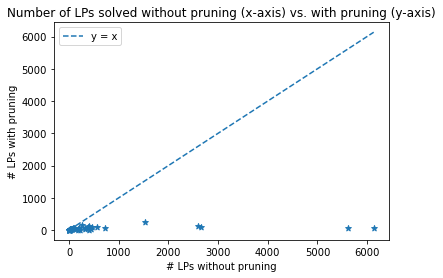

In [16]:
from matplotlib import pyplot as plt
import numpy as np 
plt.scatter(bb_without_pruning, bb_with_pruning, marker='*')
x = np.linspace(min(bb_with_pruning), max(bb_without_pruning), 400)
plt.plot(x, x, '--',label='y = x')
plt.xlabel('# LPs without pruning')
plt.ylabel('# LPs with pruning')
plt.legend()
plt.title('Number of LPs solved without pruning (x-axis) vs. with pruning (y-axis)')
plt.show()

## That's All Folks!